Import the neccessary libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

Set plotting style for better visualization

In [3]:
plt.style.use("seaborn-v0_8-whitegrid")

Configuration and Constants

In [4]:
TICKER = "KO" # Coca-cola Company stock ticker
START_DATE = "2010-01-01" # Starting date for data acquisition
END_DATE = pd.to_datetime("today").strftime("%Y-%m-%d") # Today's date as end date
PREDICTION_DAYS = 1 # We aim to predict the stock price 1 day into the future

Data Loading and Acquistion

In [5]:
print(f"Fetching {TICKER} stock data from {START_DATE} to {END_DATE}......")

# Use yfinance to download historical stock data
try:
    df = yf.download(TICKER, start=START_DATE, end=END_DATE)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()

Fetching KO stock data from 2010-01-01 to 2025-10-17......


C:\Users\Dell\AppData\Local\Temp\ipykernel_6848\987672903.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
Failed to get ticker 'KO' reason: Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
Failed to get ticker 'KO' reason: Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed

Data loaded successfully!


In [6]:
# Check if data was successfully loaded and is not empty
if df.empty:
    print(f"No data retrieved for {TICKER}. Exiting.")
    exit()

In [9]:
# Display the first few rows of the raw data
print("----- First 5 rows of the dataset -----")
df.head()

----- First 5 rows of the dataset -----


Price,Close,High,Low,Open,Volume
Ticker,KO,KO,KO,KO,KO
Date,,,,,
2010-01-04,17.557861,17.613268,17.514767,17.594799,13870400
2010-01-05,17.345463,17.542466,17.280822,17.499371,23172400
2010-01-06,17.339312,17.373170,17.231575,17.345467,19264600
2010-01-07,17.296217,17.351624,17.160778,17.339312,13234600
2010-01-08,16.976086,17.126915,16.852959,17.071508,28712400


In [10]:
# Display the last few rows of the raw data
print("----- Last 5 rows of the dataset -----")
df.tail()

----- Last 5 rows of the dataset -----


Price,Close,High,Low,Open,Volume
Ticker,KO,KO,KO,KO,KO
Date,,,,,
2025-10-10,67.040001,67.400002,66.379997,66.519997,17991700
2025-10-13,66.800003,66.800003,66.000000,66.230003,13690000
2025-10-14,67.510002,67.570000,66.750000,66.870003,14245600
2025-10-15,67.080002,67.720001,66.919998,67.269997,11193700
2025-10-16,67.589996,68.110001,67.160004,67.180000,15707200


Data Preprocessing

In [11]:
# Check for missing values 
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
Price   Ticker
Close   KO        0
High    KO        0
Low     KO        0
Open    KO        0
Volume  KO        0
dtype: int64


In [12]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


In [36]:
df.reset_index(inplace=True)

In [38]:
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,KO,KO,KO,KO,KO
0,2010-01-04,17.557861,17.613268,17.514767,17.594799,13870400
1,2010-01-05,17.345463,17.542466,17.280822,17.499371,23172400
2,2010-01-06,17.339312,17.373170,17.231575,17.345467,19264600
3,2010-01-07,17.296217,17.351624,17.160778,17.339312,13234600
4,2010-01-08,16.976086,17.126915,16.852959,17.071508,28712400


Visualization Before Training

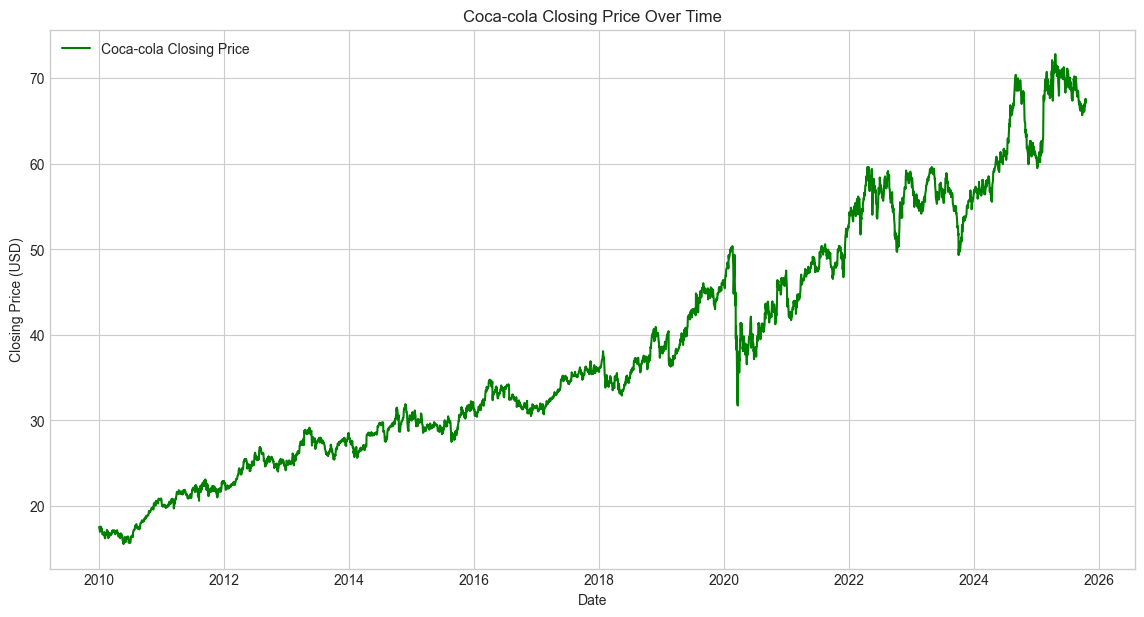

In [40]:
# Create a visualization of the raw data to show the overall trend of Coca-cola closing price
plt.figure(figsize=(14,7))
plt.plot(df["Date"],df["Close"],label="Coca-cola Closing Price",color="green")
plt.title("Coca-cola Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

Feature Engineering

In [13]:
# Create features based on the current day's trading data
features = df[["Open","High","Low","Close","Volume"]].copy()

In [14]:
# Target Variable Creation: We want to predict the "Close" price for the next day
# We shift the "Close" column upwards by -PREDICTION_DAYS (1 day) to align the future value
# (Target: y) with the current day's features (Input: X)
features["Target"] = features["Close"].shift(-PREDICTION_DAYS)

In [15]:
# Adding Simple moving averages (SMAs) as technical indicators
# SMAs smooth out price data to identify trend direction
features["SMA_5"] = features["Close"].rolling(window=5).mean()
features["SMA_20"] = features["Close"].rolling(window=20).mean()

In [17]:
# Drop rows with NaN values created by shifting and rolling window operations
# These NaNs are from the last row (Target) and first 20 rows (SMA_20)
features.dropna(inplace=True)

In [18]:
# Define the feature set (X) and the target variable (y)
X = features.drop("Target",axis=1) #  All columns except "Target" are features
y = features["Target"]

C:\Users\Dell\AppData\Local\Temp\ipykernel_6848\4176249574.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = features.drop("Target",axis=1) #  All columns except "Target" are features


In [44]:
# Store the dates corresponding to the data points for visualization
dates = features.index.values

Data Splitting

In [45]:
# Split the data into training (80%) and testing (20%) sets.
# We do not shuffle time series data, as the order is crucial
# We use a fixed split point based on the index (time)
split_point = int(0.8 * len(X))
X_train,X_test =  X[:split_point], X[split_point:]
y_train,y_test = y[:split_point], y[split_point:]
dates_test = dates[split_point:] # Keep track of test dates for plotting

In [46]:
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 3161 samples
Testing set size: 791 samples


Data Scaling

In [47]:
# Standardize features by removing the mean and scaling to unit variance
# This is crucial for distance-based algorithms like SVR and Linear models with regulatization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test) # Use the fitted scaler from the training set

In [48]:
# Convert back to DataFrame for better visualization/debugging (optional, but good practice)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)

Model Definitions and Hyperparameter Grids

In [49]:
# Define the models and their respective hyperparameter search spaces for tuning

# 1. Linear Models (Ridge/Lasso/ElasticNet): Use "alpha" (regularization strength)
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}

In [50]:
# 2. Decsion Tree: Use "max_depth" and "min_samples_split"
dt_params = {
    "max_depth" : np.arange(3,15), # Max depth of the  tree
    "min_smaples_split" : np.arange(2,10) # Minimum number of samples required to split an internal node
}

In [51]:
# 3. Random Forest: Use "n_estimators" (number of trees) and "max_depth"
rf_params = {
    "n_estimators" : np.arange(50,200,50), # Number of tree in the forest
    "max_depth" : np.arange(5,20),
    "min_samples_leaf" : [1,2,4]
}

In [52]:
# 4. SVR: Use "C" (regularization parameter) and "gamma" (kernel coefficient)
svr_params = {
    "C" : [0.1,1,10,100],
    "gamma" : ["scale","auto"], #  How much influence a single training example has
    "kernel" : ["rbf"]
}

Model Training and Comparison

In [53]:
# Define the list of models and their tuning parameters
models_to_run = [
    ("Linear Regression (Baseline)", LinearRegression(), {}), # No tuning for simple Linear Regression
    ("Ridge Regression", Ridge(), ridge_params),
    ("Lasso Regression",Lasso(max_iter=5000),lasso_params), # max_iter increased for convergence
    ("Decision Tree",DecisionTreeRegressor(random_state=42),dt_params),
    ("Random Forest",RandomForestRegressor(random_state=42),rf_params),
    ("SVR",SVR(),svr_params),
]

In [54]:
# Dictionary to store results for comparison
results = {}
best_model = None
best_score = -np.inf # Initialize with negative infinity for R-squared metric (higher is better)

In [ ]:
print("----- Model Training and Hyperparameter Tuning -----")

# ----- Model Comparison and Tuning loop -----
for name,model,params in models_to_run:
    print(f"Training and Tuning: {name}.......")

    # If parameters exits, use RandomizedSearchCV for tuning
    if params:
        # RandomizedSearchCV samples a fixed number of parameter settings from the search space
        # cv=3 means 3-fold cross-validation is used
        #  scoring="r2" means R-squared  is the metric used to evaluate the model
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=10 if name != "SVR" else 5, # Run 10 iterations (fewer for slow SVR)
            scoring="r2",
            cv=3,
            verbose=0,
            random_state=42,
            n_jobs=-1 # Use all available CPU cores
        )

        # Fit the search object to the training data. Linear models use scaled data
        if name in ["Linear Regression (Baseline)","Ridge Regression","Lasso Regression","SVR"]:
            search.fit(X_train_scaled,y_train)
        else : # Tree-based models are less sensitive to scaling

            search.fit(X_train,y_train)

            # The best estimator is the model trained with best hyparameters
            final_model = search.best_estimator_
            best_params = search.best_params_
            print(f"Best Params: {best_params}")
    else:
        # For simple Linear Regression, just fit the model directly
        final_model = model
        final_model.fit(X_train_scaled,y_train)
        best_params = "N/A"

    # Determine which feature set to use for predictions (scaled for linear/SVR, unscaled for others)
    if name in ["Linear Regression (Baseline)","Ridge Regression","Lasso Regression","SVR"]:
        X_test_pred = X_test_scaled
    else: 
        X_test_pred = X_test

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # Calcuate evaluation metrics
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    #  Store the results
    results[name] = {
        "R2 Score" : r2,
        "MSE" : mse,
        "Model" : final_model,
        "Params" : best_params,
        "Prediction" : y_pred
    }
    
    print(f"Test R² Score: {r2:.4f}")
    print(f"TEST MSE: {mse:.4f}")

    #  Check for the best model based on R-squared (coefficient of determination)
    if r2 > best_score:
        best_score = r2
        best_model_name = name
        best_model = final_model


# ----- Final Comparison and Best Model Selection -----